In [20]:
from qaenv import  mongo_ip
import pymongo
import numpy as np
import uuid
import copy
import pandas as pd
pd.set_option("display.max_rows", 100)
# pd.reset_option("display.max_rows")


import QUANTAXIS as QA
from QUANTAXIS.QAARP import QA_Risk, QA_User
from QUANTAXIS.QAEngine.QAThreadEngine import QA_Thread
from QUANTAXIS.QAUtil.QAParameter import MARKET_TYPE, RUNNING_ENVIRONMENT, ORDER_DIRECTION

from ind.ind_base import Ind_MACD_JCSC
from ind.ind_base import Ind_OBV_EX
import base.Plots as Plots

# import os
# print(os.getcwd())
%load_ext autoreload
%autoreload 2
# %cd /home/work_space/IndicatorLab/ind/ind_base
# %aimport Ind_MACD_JCSC,Ind_OBV_EX,base.Plots


class Analysis:
    def __init__(self, code_list=['000001'], frequence='day', strategy_id='x', portfolio='default',
                 start='2020-01-01', end='2020-05-21', init_cash=1000000, 
                 taskid=None, mongo_ip=mongo_ip, model='py'):
        self.username = 'admin'
        self.password = 'admin'

        self.code_list = code_list
        self.frequence = frequence
        self.strategy_id = strategy_id

        self.portfolio = portfolio

        self.start = start
        self.end = end
        self.init_cash = init_cash
        self.taskid = taskid

        self.running_time = ''

        self.model = model
        self.bar_order = {}
        self._market_data = []
        
        self.running_mode = 'backtest'
        self.market_type = MARKET_TYPE.STOCK_CN
        
        self.accounts = {}
        self.running_time = {}
        self.indicators = None
        
        self.alldata = None

    @property
    def bar_id(self):
        return len(self._market_data)
    
    @property
    def acc_portfolio(self):
        if self.accounts.get('portfolio',None) == None:
            raise Exception('需要先执行debug_portfolio')
        return self.accounts['portfolio']
    
    @property
    def inds(self):
        return self.ind_model.ind
    
    @property
    def desition(self):
        return self.ind_model.desition
    
        
    def debug_portfolio(self, is_hfq=False):
        self.database = pymongo.MongoClient(mongo_ip).QUANTAXIS
        user = QA_User(username="admin", password='admin')
        port = user.new_portfolio(self.portfolio)
        self.accounts['portfolio'] = port.new_accountpro(
            account_cookie=self.strategy_id, init_cash=self.init_cash, 
            market_type=self.market_type, frequence= self.frequence)

        data = QA.QA_quotation(self.code_list, self.start, self.end, source=QA.DATASOURCE.MONGO,
                               frequence=self.frequence, market=self.market_type, 
                               output=QA.OUTPUT_FORMAT.DATASTRUCT)
        if is_hfq:
            data = data.to_hfq()
        
        self.alldata = data
        self.ind_model = self.on_indicators_modeling(data)
        
        data.data.apply(self.x1_portfolio, axis=1)
        
        
    def x1_portfolio(self, item):
        if self.running_time.get(item.name[1], None) != None:
            if str(item.name[0])[0:10] != str(self.running_time[item.name[1]])[0:10]:
                self.on_dailyclose()
                print('backtest: Settle!')
                self.accounts['portfolio'].settle()
                self.on_dailyopen()
        self._market_data.append(copy.deepcopy(item))
        self.running_time[item.name[1]] = str(item.name[0])
        self.on_bar(item, self.accounts['portfolio'])
                
    def on_dailyclose(self):
        pass
    def on_dailyopen(self):
        pass
    def on_bar(self, bar, account):
        raise NotImplementedError
        
    def on_indicators_modeling(self, data):
        raise NotImplementedError
        
        
    def send_order(self,account, direction='BUY', code=None, price=3925, volume=10, order_id=''):
        towards = direction
        order_id = str(uuid.uuid4()) if order_id == '' else order_id

        if towards == 'BUY':
            towards = ORDER_DIRECTION.BUY
        elif towards == 'SELL':
            towards = ORDER_DIRECTION.SELL

        if isinstance(price, float):
            pass
        elif isinstance(price, pd.Series):
            price = price.values[0]
    
        self.bar_order['{}_{}'.format(code, direction)] = self.bar_id

        account.receive_simpledeal(
            code=code, trade_time=self.running_time[code], trade_towards=towards, trade_amount=volume, trade_price=price, order_id=order_id)
            


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class test(Analysis):
    def on_indicators_modeling(self, data):
        OBV = Ind_OBV_EX.OBV(data, self.frequence)
        OBV.set_fast_mode(False)
        OBV.fit()
        return OBV
#         MACD = Ind_MACD_JCSC.MACD_JCSC(data, self.frequence)
# #         d = {'SHORT':10,'LONG':19,'M':7}
#         MACD.change_pramas(M=8,LONG=10,SHORT=5)
#         MACD.reset_pramas()
#         print(MACD)
#         MACD.fit()
#         print(MACD)
#         return MACD
        
    def on_bar(self, bar, acc):
        current_code = bar.name[1]

        res = self.desition.get_ind_for_train(current_code,bar.name[0])[0]
#         print(acc.cash_available)
#         print(bar.name[0],current_code)
#         print(self.indicators.get_ind(current_code,bar.name[0]))
        
        if res == 1:
            print('LONG',current_code, acc.get_position(current_code).volume_long)
            self.send_order(acc, 'BUY', price=bar['close'], volume=10000, code= current_code)
        elif res == -1:
            print('SHORT',current_code, acc.get_position(current_code).volume_long)
            if acc.get_position(current_code).volume_long > 0:
                self.send_order(acc, 'SELL', price=bar['close'], volume=10000, code= current_code)

    def randddd(self, code):
        return np.random.randint(0,9)

In [3]:
%%time

t = test(code_list=['000001', '000002'], frequence=QA.FREQUENCE.DAY , start='2020-01-01', end='2020-05-21', strategy_id='x')
t.debug_portfolio(is_hfq=True)

 prortfolio with user_cookie  USER_3NnZodJv  already exist!!
QAACCPRO: reload from DATABASE
{}
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000001 0
backtest: Settle!
LONG 000002 0
backtest: Settle!
SHORT 000001 10000
backtest: Settle!
backtest: Settle!
backtest: Settle!
SHORT 000002 10000
backtest: Settle!
LONG 000001 0
backtest: Settle!
LONG 000002 0
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
b

/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:150: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.init_hold = pd.Series(
/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:1472: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.init_hold = pd.Series(message.get('init_hold', {}), name='amount')


SHORT 000001 10000
backtest: Settle!
LONG 000002 0
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000001 0
backtest: Settle!
SHORT 000002 10000
backtest: Settle!
SHORT 000001 10000
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000002 0
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000001 0
backtest: Settle!
backtest: Settle!
SHORT 000001 10000
backtest: Settle!
SHORT 000002 10000
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000001 0
backtest: Settle!
backtest: Settle!
SHORT 000001 10000
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
LONG 000002 0
backtest: Settle!
LONG 000001 0
backtest: Settle!
SHORT 000002 10000
backtest: Settle!
backtest: Set

In [4]:
t.alldata.type

'stock_day'

In [14]:
%%time
# t.ind_model.desition.data
# t.ind_model.ind.data
# Plots.base_plot('000001',t.alldata)
# t.ind_model.ind.get_ind_offset('000001','2019-08-05',-1).iloc[0]
t.ind_model.desition.get_ind_for_train('000001','2020-04-01')

CPU times: user 722 µs, sys: 0 ns, total: 722 µs
Wall time: 682 µs


res   -1
Name: 2020-03-31 00:00:00, dtype: int64

CPU times: user 12.2 ms, sys: 12 µs, total: 12.2 ms
Wall time: 11.7 ms


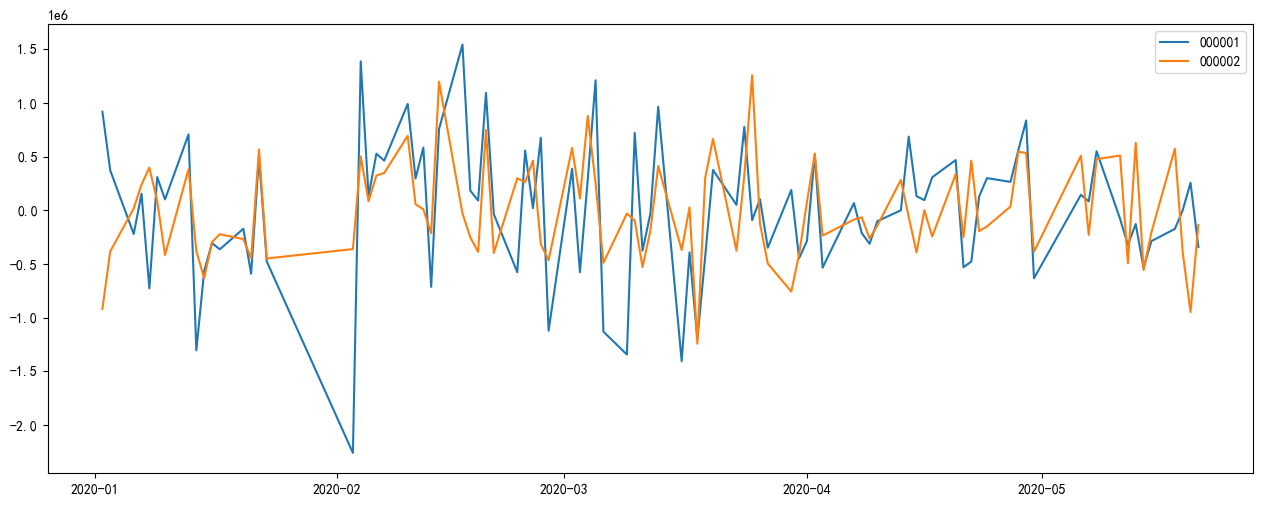

In [16]:
%%time
# t.ind_model.plot()
t.ind_model.plot_mix()


/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:669: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(
/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:669: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(
/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:669: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(
/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QAAccountPro.py:669: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(
/home/work_s

[]

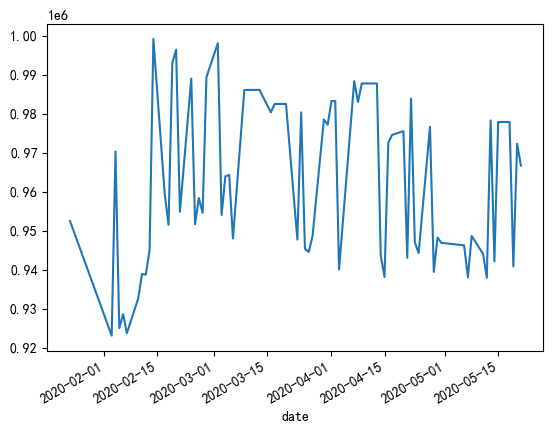

In [17]:
Risk = QA.QA_Risk(t.acc_portfolio)
fig = Risk.assets.plot()
fig.plot()

[]

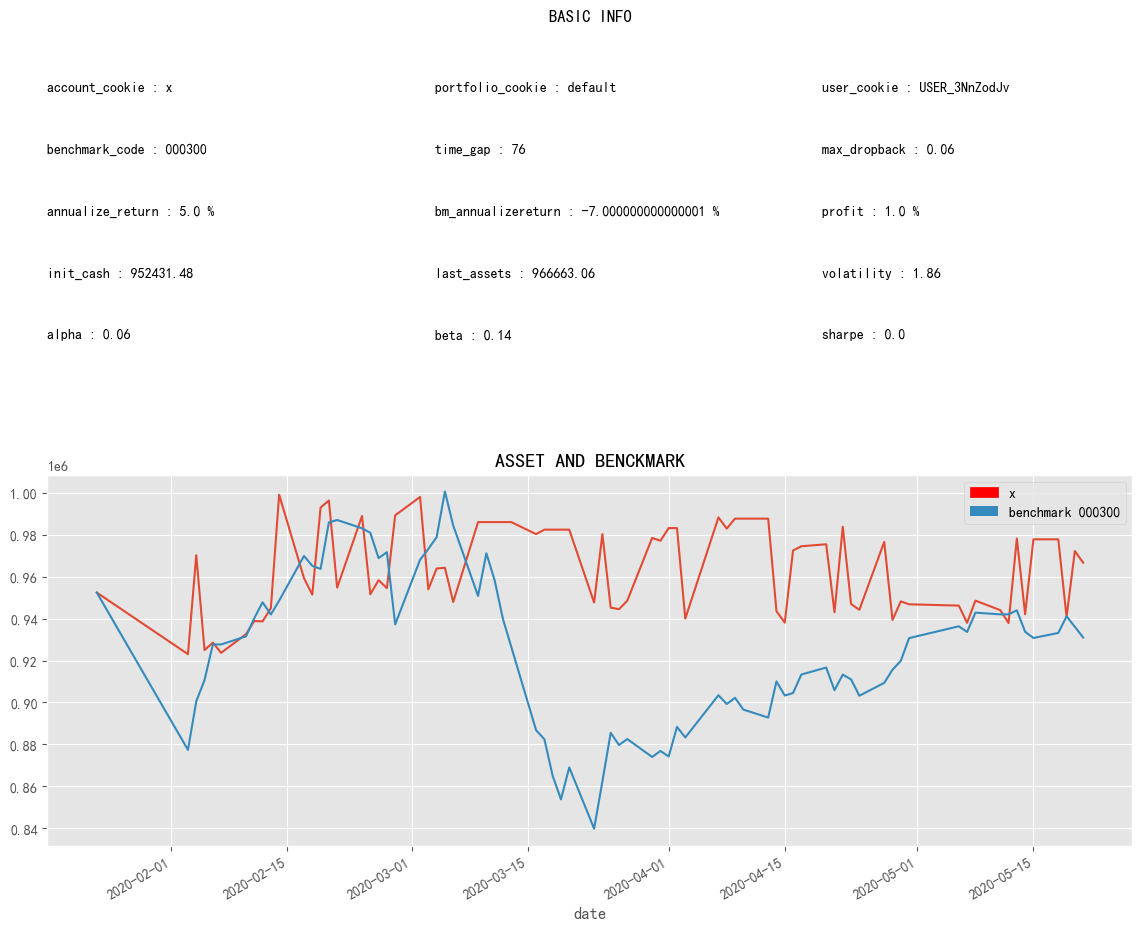

In [18]:
fig = Risk.plot_assets_curve()
fig.plot()
# Risk.message

/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QARisk.py:1629: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, item in pnl.pnl_money.iteritems():
/home/work_space/QUANTAXIS_Learning/QUANTAXIS/QAARP/QARisk.py:1651: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, item in pnl.pnl_money.iteritems():


{'total_profit': 63300.0,
 'total_loss': -82400.0,
 'total_pnl': 0.77,
 'trading_amounts': 27,
 'profit_amounts': 12,
 'loss_amounts': 14,
 'even_amounts': 1,
 'profit_precentage': 0.44,
 'loss_precentage': 0.52,
 'even_precentage': 0.04,
 'average_profit': 5275.0,
 'average_loss': -5885.71,
 'average_pnl': 0.9,
 'max_profit': 31600.0,
 'max_loss': -15500.0,
 'max_pnl': 2.04,
 'netprofio_maxloss_ratio': 1.23,
 'continue_profit_amount': 3,
 'continue_loss_amount': 3,
 'average_holdgap': '5 days 04:26:40',
 'average_profitholdgap': '5 days 22:00:00',
 'average_losssholdgap': '4 days 20:34:17.142857142',
 'buyopen': {'total_profit': 63300.0,
  'total_loss': -82400.0,
  'total_pnl': 0.77,
  'trading_amounts': 27,
  'profit_amounts': 12,
  'loss_amounts': 14,
  'even_amounts': 1,
  'profit_precentage': 0.44,
  'loss_precentage': 0.52,
  'even_precentage': 0.04,
  'average_profit': 5275.0,
  'average_loss': -5885.71,
  'average_pnl': 0.9,
  'max_profit': 31600.0,
  'max_loss': -15500.0,
  'm

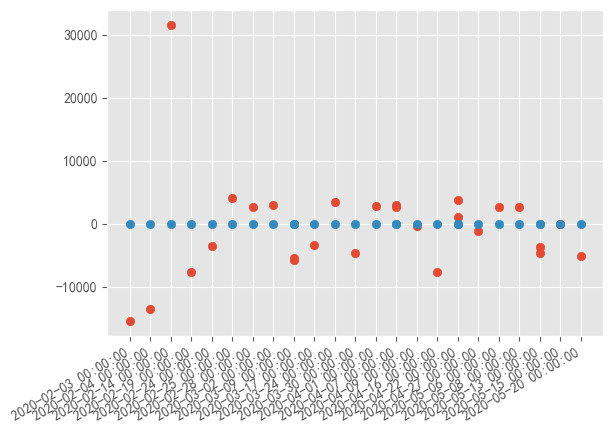

In [19]:
pr=QA.QA_Performance(t.accounts['portfolio'])
pr.pnl_fifo
pr.plot_pnlmoney()
pr.plot_pnlratio()
pr.message